# Question 3: Simulation

Statistiques sommaires des rendements simulés :

                              Moyenne  Écart-type  Asymétrie  \
Normale standard               0.0237      1.0044    -0.0191   
Student-t (df=3, normalisée)  -0.0320      0.8979    -0.2371   

                              Aplatissement (kurtosis)  
Normale standard                                0.0188  
Student-t (df=3, normalisée)                   10.2730   



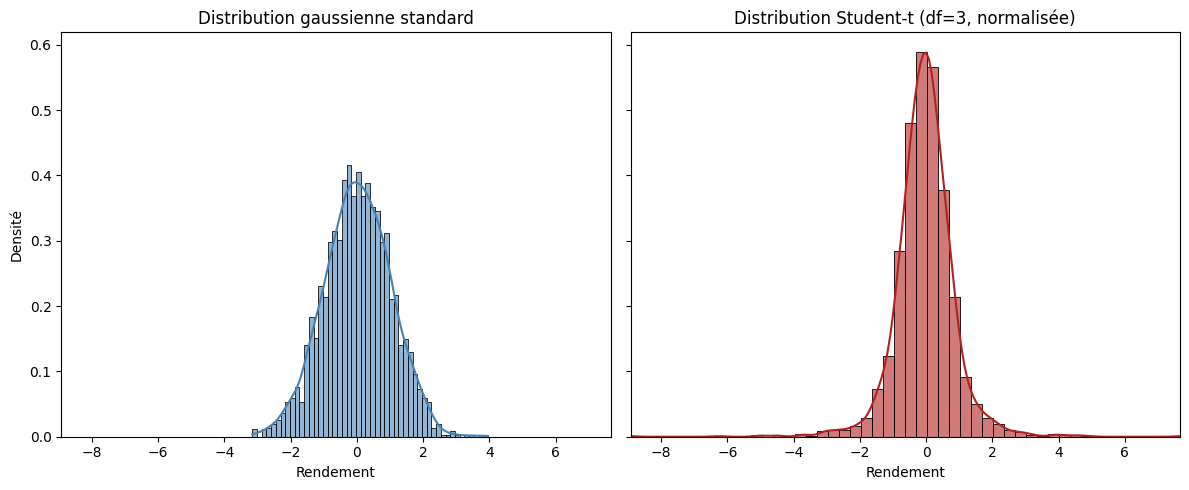

In [46]:
# Partie a : Simulation des rendements selon une loi normale et une loi student-t normalisée

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 1. Paramètres de simulation
n = 2500 # longueur des séries de rendements (déterminée de manière arbitraire)
df = 3 # degrés de liberté pour la Student-t (mentionnée dans l'énoncé)
np.random.seed(1) # Fixe la graine du générateur de nombres aléatoires pour que les résultats soient reproductibles (donc les mêmes à chaque exécution). Le nombre 1 a été choisi arbitrairement.

# 2. Génération des rendements
returns_normal = np.random.normal(loc=0, scale=1, size=n) # Normal (0,1)
returns_t = np.random.standard_t(df=df, size=n) # Student-t(df)

# 3. Normalisation de la variance
var_t_theoretical = df / (df - 2)  # variance théorique Student-t(df)
scale_factor = np.sqrt(1 / var_t_theoretical) # calcul de combien réduire l’échelle pour normaliser la variance à 1
returns_t_scaled = returns_t * scale_factor  # application de la réduction d'échelle

# 4. Statistiques sommaires
def summary_stats(data):
    return {
        "Moyenne": np.mean(data),
        "Écart-type": np.std(data, ddof=1),
        "Asymétrie": skew(data),
        "Aplatissement (kurtosis)": kurtosis(data, fisher=True)} # fisher=True pour obtenir l'excès de kurtosis

stats_normal = summary_stats(returns_normal)
stats_t = summary_stats(returns_t_scaled)

summary_df = pd.DataFrame([stats_normal, stats_t], index=["Normale standard", "Student-t (df=3, normalisée)"])

print("Statistiques sommaires des rendements simulés :\n")
print(summary_df.round(4), "\n")

# 5. Visualisation : deux graphiques côte à côte avec mêmes axes afin de faciliter la comparaison
# Déterminer les mêmes limites sur x et y
x_min = min(returns_normal.min(), returns_t_scaled.min())
x_max = max(returns_normal.max(), returns_t_scaled.max())

# Préparer la figure
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Graphique 1 : Normale
sns.histplot(returns_normal, bins=50, kde=True, stat="density", color="steelblue", alpha=0.6, ax=axes[0])
axes[0].set_title("Distribution gaussienne standard")
axes[0].set_xlabel("Rendement")
axes[0].set_ylabel("Densité")
axes[0].set_xlim(x_min, x_max)

# Graphique 2 : Student-t
sns.histplot(returns_t_scaled, bins=50, kde=True, stat="density", color="firebrick", alpha=0.6, ax=axes[1])
axes[1].set_title("Distribution Student-t (df=3, normalisée)")
axes[1].set_xlabel("Rendement")
axes[1].set_ylabel("Densité")
axes[1].set_xlim(x_min, x_max)

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


In [ ]:
# Partie b : Calcul de la VaR et du déficit attendu (ES) de 3 différentes manières

import numpy as np
import pandas as pd
from scipy.stats import norm, t

alpha = 0.05  # niveau pour VaR/ES
nu = 3        # degrés de liberté pour l'approche t

# Méthodes de calcul VaR / ES
# (i) Empirique
def var_es_empirique(x, a=alpha):
    var_ = np.quantile(x, a)
    es_  = x[x <= var_].mean() if np.any(x <= var_) else np.nan
    return var_, es_

# (ii) Paramétrique gaussienne
def var_es_gauss(x, a=alpha):
    mu, sig = np.mean(x), np.std(x, ddof=1)
    z = norm.ppf(a)
    var_ = mu + sig * z
    es_  = mu - sig * norm.pdf(z) / a
    return var_, es_

# (iii) Paramétrique t (df connus)
def var_es_t(x, a=alpha, df=nu):
    """
    Modèle: R = mu + sigma * Z, avec Var(Z)=1 et Z ~ t(df) standardisée.
    Pour Y ~ t_df (scale=1): Var(Y)=df/(df-2), donc Z = c*Y, c = sqrt((df-2)/df).
    ES(Y | Y<=q) = - ((df + q^2)/((df-1)*a)) * f_t(q)
    """
    mu, sig = np.mean(x), np.std(x, ddof=1)
    q_y = t.ppf(a, df=df)       # quantile de Y
    f_y = t.pdf(q_y, df=df)     # densité en q_y
    c = np.sqrt((df - 2) / df)  # normalise à Var=1

    var_z = c * q_y
    es_y  = - (df + q_y**2) / ((df - 1) * a) * f_y
    es_z  = c * es_y

    var_ = mu + sig * var_z
    es_  = mu + sig * es_z
    return var_, es_

# Construction d'un tableau récapitulatif pour chaque méthode
def table_empirique(series_dict, a=alpha):
    rows = []
    for nom, x in series_dict.items():
        v, e = var_es_empirique(np.asarray(x), a=a)
        rows.append({"Série": nom, "VaR 5%": v, "ES 5%": e})
    return pd.DataFrame(rows)

def table_gaussienne(series_dict, a=alpha):
    rows = []
    for nom, x in series_dict.items():
        v, e = var_es_gauss(np.asarray(x), a=a)
        rows.append({"Série": nom, "VaR 5%": v, "ES 5%": e})
    return pd.DataFrame(rows)

def table_student(series_dict, a=alpha, df=nu):
    rows = []
    for nom, x in series_dict.items():
        v, e = var_es_t(np.asarray(x), a=a, df=df)
        rows.append({"Série": nom, "VaR 5%": v, "ES 5%": e})
    return pd.DataFrame(rows)

# Utilisation des séries simulées précedemment
series = {
    "Distribution gaussienne standard": returns_normal,
    f"Distribution de Student-t (df={nu})": returns_t_scaled,}

# Mise en place des tableaux récapitulatifs
tbl_empirique = table_empirique(series).round(4)
tbl_gauss     = table_gaussienne(series).round(4)
tbl_student   = table_student(series, df=nu).round(4)

print("\nMéthode (i) : Quantile empirique ")
print(tbl_empirique.to_string(index=False))

print("\nMéthode (ii) : Paramétrique gaussienne")
print(tbl_gauss.to_string(index=False))

print(f"\nMéthode (iii) : Paramétrique t (df={nu})")
print(tbl_student.to_string(index=False))



Méthode (i) : Quantile empirique 
                           Série  VaR 5%   ES 5%
Distribution gaussienne standard -1.6184 -2.0752
Distribution de Student-t (df=3) -1.3202 -2.1141

Méthode (ii) : Paramétrique gaussienne
                           Série  VaR 5%   ES 5%
Distribution gaussienne standard -1.6284 -2.0481
Distribution de Student-t (df=3) -1.5090 -1.8842

Méthode (iii) : Paramétrique t (df=3)
                           Série  VaR 5%   ES 5%
Distribution gaussienne standard  -1.341 -2.2230
Distribution de Student-t (df=3)  -1.252 -2.0405


VaR 5% (échantillon original) : -1.3202
IC 95% (bootstrap percentile) : [-1.4179, -1.2097]
Largeur de l'IC : 0.2082


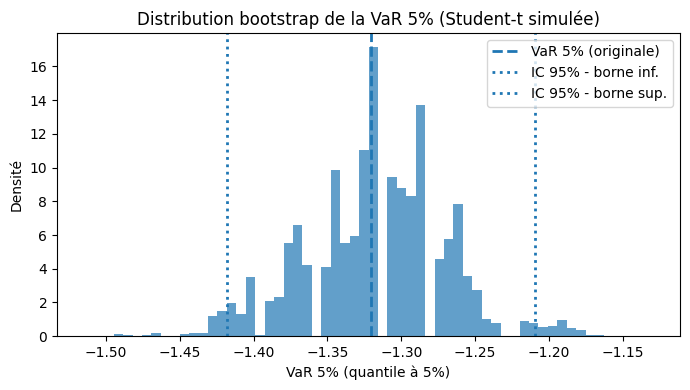

In [64]:
# Partie c : Bootstrap de la VaR empirique (5%) à partir de la série Student-t simulée

import numpy as np
import matplotlib.pyplot as plt

alpha = 0.05         # niveau de VaR (queue gauche)
B = 10000            # nombre de rééchantillonnages
rng = np.random.default_rng(1)  # graine pour reproductibilité

# On réutilise le 'returns_t_scaled' de la partie a.
x = returns_t_scaled
n = x.size

# 1) VaR empirique sur l'échantillon original
var_hat = np.quantile(x, alpha)

# 2) Bootstrap (rééchantillonnage avec remise): 
# On échantillonne des indices, puis on calcule la VaR 5% sur chaque pseudo-échantillon.
idx = rng.integers(low=0, high=n, size=(B, n))
x_boot = x[idx]                                    
var_boot = np.quantile(x_boot, alpha, axis=1)      

# 3) Intervalle de confiance 95% (méthode percentile) + largeur
ci_low, ci_high = np.percentile(var_boot, [2.5, 97.5]) # Comme la distribution n'est pas normale, on utilise les percentiles
width = ci_high - ci_low

print(f"VaR 5% (échantillon original) : {var_hat:.4f}")
print(f"IC 95% (bootstrap percentile) : [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Largeur de l'IC : {width:.4f}")

# 4) Tracé de la distribution bootstrap
plt.figure(figsize=(7,4))
plt.hist(var_boot, bins=60, density=True, alpha=0.7)
plt.axvline(var_hat, linestyle="--", linewidth=2, label="VaR 5% (originale)")
plt.axvline(ci_low, linestyle=":", linewidth=2, label="IC 95% - borne inf.")
plt.axvline(ci_high, linestyle=":", linewidth=2, label="IC 95% - borne sup.")
plt.title("Distribution bootstrap de la VaR 5% (Student-t simulée)")
plt.xlabel("VaR 5% (quantile à 5%)")
plt.ylabel("Densité")
plt.legend()
plt.tight_layout()
plt.show()

 VaR 5% (rendements) 
            Méthode    VaR 5%
          Empirique -0.029373
Paramétrique N(μ,σ) -0.049876
      EWMA (λ=0.94) -0.036696


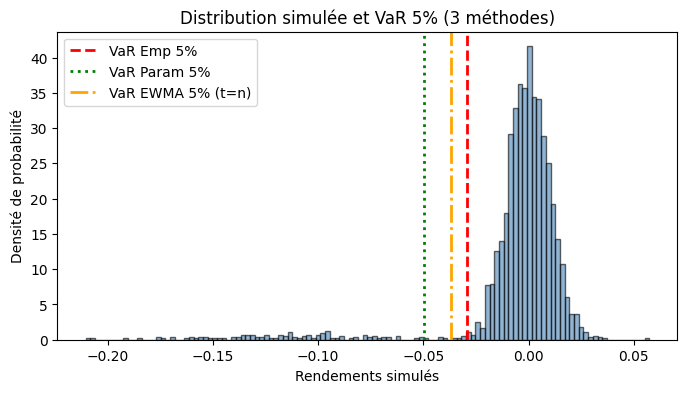

In [65]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Paramètres
n = 2500              # taille de l'échantillon
p_crash = 0.05          # probabilité d'un krach
mu_norm,  sigma_norm  = 0.00, 0.01   # 95%: N(0, 1%)
mu_crash, sigma_crash = -0.10, 0.04  # 5% : N(-10%, 4%)
seed = 1               # graine pour reproductibilité

# EWMA (RiskMetrics)
lam = 0.94              # facteur d'oubli (tel qu'utilisé dans le problème 2)
alpha = 0.05            # niveau de VaR (5%)

rng = np.random.default_rng(seed)

# 1) Simulation avec les deux scénarios
regime = rng.uniform(size=n) >= p_crash   # True -> régime "normal", False -> "krach"
r = np.empty(n) # Création d'un tableau vide pour les rendements
r[regime]  = rng.normal(mu_norm,  sigma_norm,  regime.sum()) # Génère des rendements normaux, assignées uniquement aux positions “régime normal” (True)
r[~regime] = rng.normal(mu_crash, sigma_crash, (~regime).sum()) # Génère des rendements de krach pour les positions “krach” (False) : on inverse les booléens
returns = pd.Series(r, name="r")

# 2) VaR 5% à l'aide des trois méthodes

# (1) VaR empirique (historique)
var_emp = returns.quantile(alpha)

# (2) VaR paramétrique gaussienne (μ, σ de l'échantillon)
mu_hat  = returns.mean()
sig_hat = returns.std(ddof=1)
z_a     = norm.ppf(alpha)      
var_param = mu_hat + z_a * sig_hat

# (3) VaR EWMA (méthode récursive de volatilité) : sigma_t^2 = (1-λ)*r_{t-1}^2 + λ*sigma_{t-1}^2
sigma2 = np.empty(n)
# init avec la variance in-sample
sigma2[0] = returns.var(ddof=1)
for t in range(1, n):
    sigma2[t] = (1 - lam) * returns.iloc[t-1]**2 + lam * sigma2[t-1]

sigma_ewma = np.sqrt(sigma2)
# RiskMetrics suppose μ≈0 au quotidien ; VaR_{t|t-1} = z_a * σ_t
var_ewma_series = z_a * sigma_ewma
var_ewma = var_ewma_series[-1]  # prévision "one-step-ahead" finale

# 3) Récapitulatif
summary = pd.DataFrame({
    "Méthode": ["Empirique", "Paramétrique N(μ,σ)", "EWMA (λ=%.2f)" % lam],
    "VaR 5%": [var_emp, var_param, var_ewma]})


print(" VaR 5% (rendements) ")
print(summary.to_string(index=False))

# 4) Visualisation: Histogramme + VaR 
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(returns, bins=120, density=True, color='steelblue', alpha=0.6, edgecolor='black')

ax.axvline(var_emp,   color='red',    linestyle='--',  linewidth=2, label='VaR Emp 5%')
ax.axvline(var_param, color='green',  linestyle=':',   linewidth=2, label='VaR Param 5%')
ax.axvline(var_ewma,  color='orange', linestyle='-.',  linewidth=2, label='VaR EWMA 5% (t=n)')

ax.set_title("Distribution simulée et VaR 5% (3 méthodes)", fontsize=12)
ax.set_xlabel("Rendements simulés")
ax.set_ylabel("Densité de probabilité")
ax.legend()

plt.show()


10000 rééchantillons bootstrap générés.
Pour chaque rééchantillon, la VaR Gaussienne et la VaR Empirique ont été calculées.
--------------------------------------------------
--- Résultats de la Simulation Bootstrap ---
           Méthode VaR Taux de Violation Moyen Alpha Cible Distorsion de Taille
            Gaussienne                   3.73%       5.00%               -1.27%
Empirique (Historique)                   5.03%       5.00%                0.03%
--------------------------------------------------


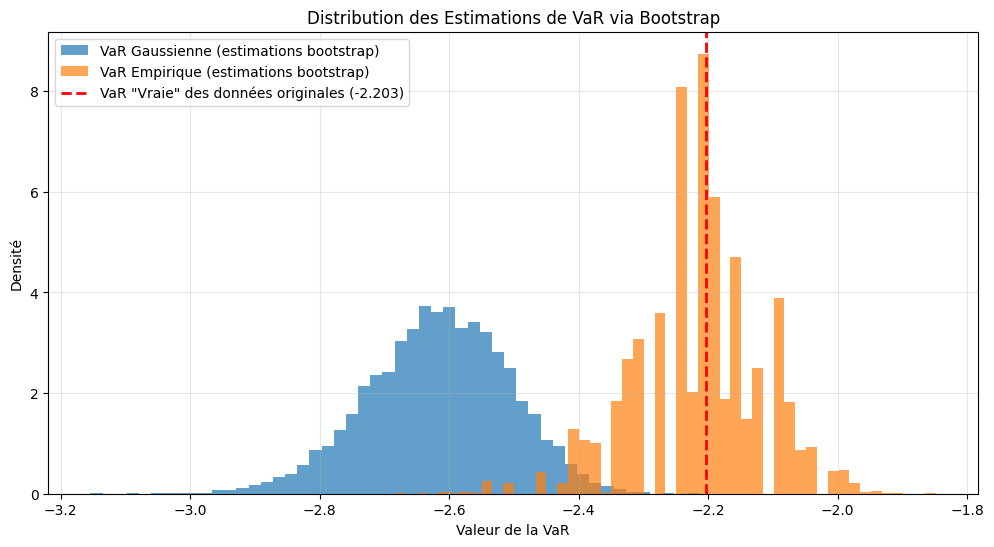

In [59]:
# Partie e : Comparaison entre VaR Gaussienne et Empirique pour une distribution t à 3 degrés de liberté
import numpy as np
from scipy.stats import t, norm
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Effacer l'output précédent pour éviter les doublons
clear_output(wait=True)

# --- 1. Configuration de la Simulation ---
np.random.seed(123)  # Pour la reproductibilité
n_obs = 2500        # Nombre d'observations dans la série de rendements originale
n_bootstraps = 10000   # Nombre de rééchantillons bootstrap
df_student = 3       # Degrés de liberté pour une distribution proche de la normale
alpha = 0.05          # Niveau de la VaR (5%)

# --- 2. Simulation de la Série de Rendements Initiale ---
# Simuler une série de rendements à partir d'une distribution Student-t
# pour représenter une série avec des queues épaisses.
original_returns = t.rvs(df=df_student, size=n_obs)

# --- 3. Procédure Bootstrap ---
# Listes pour stocker les estimations de VaR de chaque échantillon bootstrap
bootstrap_var_gaussian = []
bootstrap_var_empirical = []

for i in range(n_bootstraps):
    # Générer un rééchantillon bootstrap en tirant avec remise de la série originale
    bootstrap_sample = np.random.choice(original_returns, size=n_obs, replace=True)
    
    # a) Calculer la VaR Gaussienne pour le rééchantillon
    # On suppose (à tort) que l'échantillon suit une loi normale.
    mean_boot = np.mean(bootstrap_sample)
    std_boot = np.std(bootstrap_sample)
    var_gauss = norm.ppf(alpha, loc=mean_boot, scale=std_boot)
    bootstrap_var_gaussian.append(var_gauss)
    
    # b) Calculer la VaR Empirique (Historique) pour le rééchantillon
    # On utilise simplement le percentile de l'échantillon.
    var_emp = np.percentile(bootstrap_sample, 100 * alpha)
    bootstrap_var_empirical.append(var_emp)

print(f"{n_bootstraps} rééchantillons bootstrap générés.")
print("Pour chaque rééchantillon, la VaR Gaussienne et la VaR Empirique ont été calculées.")
print("-" * 50)
# --- 4. Évaluation de la Couverture et de la Distorsion ---
# Convertir les listes en arrays numpy pour les calculs vectoriels
bootstrap_var_gaussian = np.array(bootstrap_var_gaussian)
bootstrap_var_empirical = np.array(bootstrap_var_empirical)

# Calculer la proportion de fois où chaque estimation de VaR est violée par les rendements ORIGINAUX.
# Une violation se produit si un rendement original est inférieur à la VaR estimée.
# Nous calculons le taux de violation moyen sur toutes les estimations de VaR bootstrap.
violation_rates_gaussian = [np.mean(original_returns < var) for var in bootstrap_var_gaussian]
violation_rates_empirical = [np.mean(original_returns < var) for var in bootstrap_var_empirical]

# Taux de violation moyen
mean_violation_rate_gaussian = np.mean(violation_rates_gaussian)
mean_violation_rate_empirical = np.mean(violation_rates_empirical)
mean_violation_rate_empirical = np.mean(violation_rates_empirical)
# Calculer la distorsion de taille (biais)
# C'est la différence entre le taux de violation observé et le taux attendu (alpha).
size_distortion_gaussian = mean_violation_rate_gaussian - alpha
size_distortion_empirical = mean_violation_rate_empirical - alpha

# --- 5. Affichage des Résultats ---
results = pd.DataFrame({
    "Méthode VaR": ["Gaussienne", "Empirique (Historique)"],
    "Taux de Violation Moyen": [mean_violation_rate_gaussian, mean_violation_rate_empirical],
    "Alpha Cible": [alpha, alpha],
    "Distorsion de Taille": [size_distortion_gaussian, size_distortion_empirical]
})

print("--- Résultats de la Simulation Bootstrap ---")
print(results.to_string(index=False, formatters={
    "Taux de Violation Moyen": "{:.2%}".format,
    "Alpha Cible": "{:.2%}".format,
    "Distorsion de Taille": "{:.2%}".format
}))
print("-" * 50)

# Visualisation des distributions des VaR estimées
plt.figure(figsize=(12, 6))
plt.hist(bootstrap_var_gaussian, bins=50, alpha=0.7, label='VaR Gaussienne (estimations bootstrap)', density=True)
plt.hist(bootstrap_var_empirical, bins=50, alpha=0.7, label='VaR Empirique (estimations bootstrap)', density=True)
plt.axvline(np.percentile(original_returns, 100 * alpha), color='red', linestyle='--', lw=2, label=f'VaR "Vraie" des données originales ({np.percentile(original_returns, 100 * alpha):.3f})')
plt.title('Distribution des Estimations de VaR via Bootstrap')
plt.xlabel('Valeur de la VaR')
plt.ylabel('Densité')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()